In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
import random
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.callbacks import EarlyStopping
from wordcloud import WordCloud, STOPWORDS

In [2]:
df = pd.read_csv('./Tweets.csv')

df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [4]:
# cek null
df.isna().sum()

tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [5]:
# cek data unik
df.nunique()

tweet_id                        14485
airline_sentiment                   3
airline_sentiment_confidence     1023
negativereason                     10
negativereason_confidence        1410
airline                             6
airline_sentiment_gold              3
name                             7701
negativereason_gold                13
retweet_count                      18
text                            14427
tweet_coord                       832
tweet_created                   14247
tweet_location                   3081
user_timezone                      85
dtype: int64

In [6]:
print('Persentase data null pada dataset')
((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2)

Persentase data null pada dataset


tweet_id                         0.00
airline_sentiment                0.00
airline_sentiment_confidence     0.00
negativereason                  37.31
negativereason_confidence       28.13
airline                          0.00
airline_sentiment_gold          99.73
name                             0.00
negativereason_gold             99.78
retweet_count                    0.00
text                             0.00
tweet_coord                     93.04
tweet_created                    0.00
tweet_location                  32.33
user_timezone                   32.92
dtype: float64

hapus data yang persentase nullnya tinggi

In [7]:
del df['tweet_coord']
del df['airline_sentiment_gold']
del df['negativereason_gold']
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,cairdin,0,@VirginAmerica What @dhepburn said.,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,yvonnalynn,0,@VirginAmerica I didn't today... Must mean I n...,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64
--------------------------------------------------------------------------------


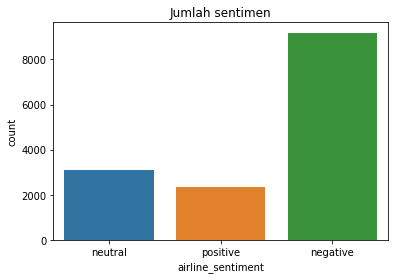

In [8]:
airline_sentiment_values = df['airline_sentiment'].value_counts()
print(airline_sentiment_values)
print('--'*40)
sns.countplot(x='airline_sentiment', data=df)
plt.title('Jumlah sentimen')
plt.show()

Text(0.5, 1.0, 'Jumlah Komen untuk setiap maskapai')

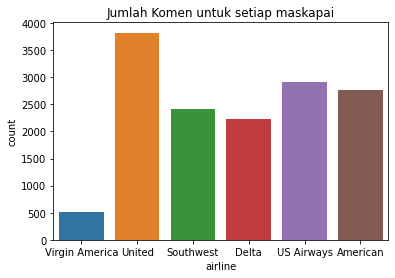

In [9]:
sns.countplot(x='airline', data=df)
plt.title('Jumlah Komen untuk setiap maskapai')

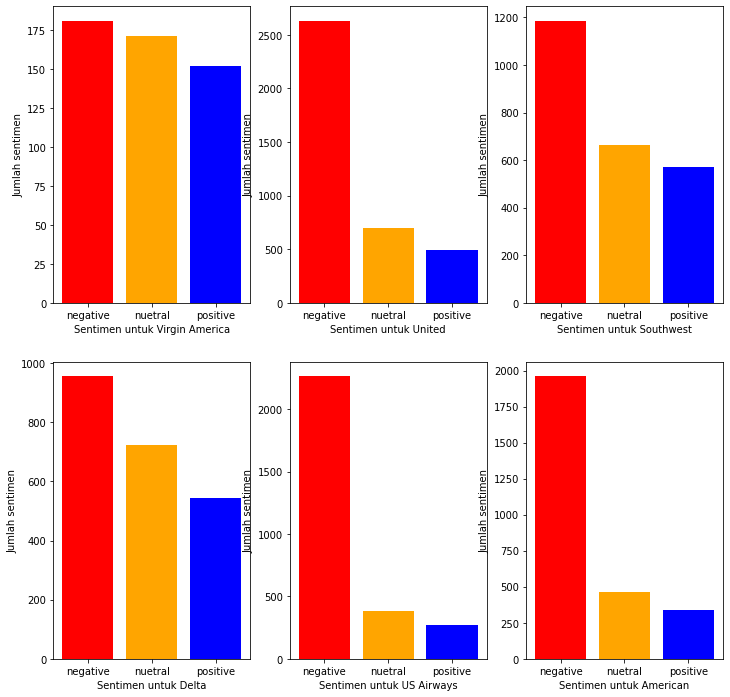

In [10]:
airline = df['airline'].unique().tolist()

plt.figure(1, figsize=(12,12))

for i in airline:
  indices=airline.index(i)
  plt.subplot(2,3,indices+1)
  new_df=df[df["airline"]==i]
  count=new_df['airline_sentiment'].value_counts()
  Index=[1,2,3]
  plt.bar(Index,count,color=['red','orange','blue'])
  plt.xticks(Index,['negative','nuetral','positive'])
  plt.ylabel("Jumlah sentimen")
  plt.xlabel("Sentimen untuk " + i)

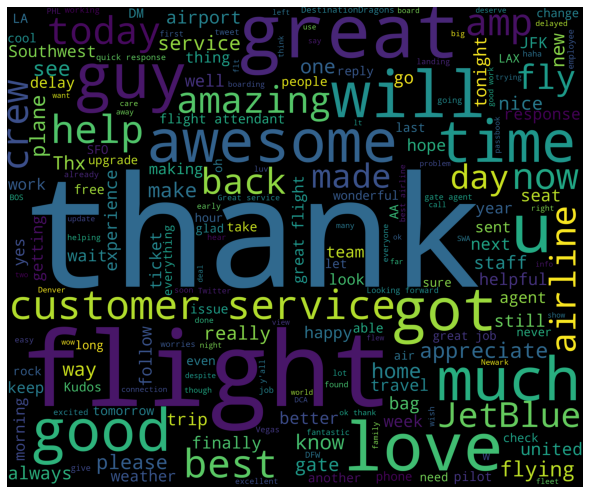

In [11]:
df_positive=df[df['airline_sentiment']=='positive']
words = ' '.join(df_positive['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

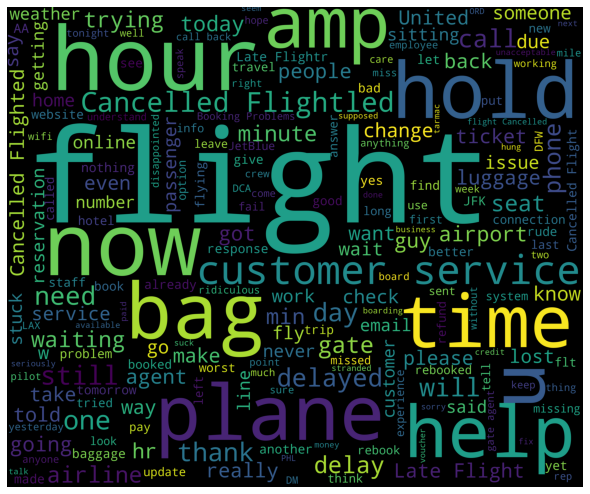

In [12]:
df_negative=df[df['airline_sentiment']=='negative']
words = ' '.join(df_negative['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)
plt.figure(figsize=(8,8), facecolor=None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [13]:
df = df[['text', 'airline_sentiment']]
df = df[df['airline_sentiment'] != 'neutral']

In [14]:
# diubah ke lowercase
df['text'] = df['text'].apply(lambda words: words.lower())
# hapus punctuation
df['text'] = df['text'].apply(lambda words: re.sub('[^a-zA-Z]', ' ', words))
print(df['text'][1])

 virginamerica plus you ve added commercials to the experience    tacky 


In [15]:
def remove_stopwords(text):
  stops = set(stopwords.words("english"))
  text_tokens = word_tokenize(text)
  text_non_sw = [w for w in text_tokens if not w in stops]
  return " ".join(text_non_sw)
  

In [16]:
df['text'] = df['text'].apply(lambda words: remove_stopwords(words))
df['text'][1]
# df.head()

'virginamerica plus added commercials experience tacky'

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64


<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

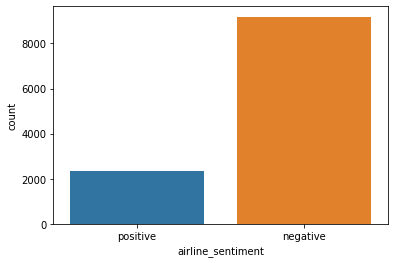

In [17]:
print(df['airline_sentiment'].value_counts())
sns.countplot(x='airline_sentiment', data=df)

Karena terjadi overfitting pada dataset ini yang mana untuk label negative jauh lebih banyak dibandingkan label positive. maka disini saya lakukan oversampling untuk data positive dengan data augmentaion menggunakan teknik synonym replacement

In [18]:
def get_synonyms(word):
  synonyms = set()
  for syn in wordnet.synsets(word):
    for l in syn.lemmas():
      synonym = l.name().replace("_", " ").replace(" ", "_").lower()
      synonym = "".join([char for char in synonym if char in 'qwertyuiopasdfghjklzxcvbnm'])
      synonyms.add(synonym)
  
  if word in synonyms:
    synonyms.remove(word)
  return list(synonyms)

In [19]:
def synonym_replacement(words, n):
  words = words.split()
  
  new_words = words.copy()
  new_words_list = [word for word in new_words]
  random.shuffle(new_words_list)
  num_replaced = 0
  
  for random_word in new_words_list:
    synonyms = get_synonyms(random_word)
    
    if len(synonyms):
      synonym = random.choice(list(synonyms))
      new_words = [synonym if word == random_word else word for word in new_words]
      num_replaced += 1
    
    if num_replaced >= n:
      break
  
  return ' '.join(new_words)

In [20]:
positive_sentiments = df.loc[df['airline_sentiment'] == 'positive'].values.tolist()
new_sentiments = list()
# print(positive_sentiments[2])
for i in range(0,3):
  for sentiment in positive_sentiments:
    randInt = random.randint(1,3)
    sentiment = synonym_replacement(sentiment[0], randInt)
    new_sentiments.append([sentiment, 'positive'])
new_sentiments = set(tuple(element) for element in new_sentiments)
new_df = pd.DataFrame(data=new_sentiments, columns=['text','airline_sentiment'])
df = df.append(new_df)
df = df.drop_duplicates()

C:\Users\USER\AppData\Local\Temp/ipykernel_18796/1655279568.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(new_df)


negative    9073
positive    8806
Name: airline_sentiment, dtype: int64


<AxesSubplot:xlabel='airline_sentiment', ylabel='count'>

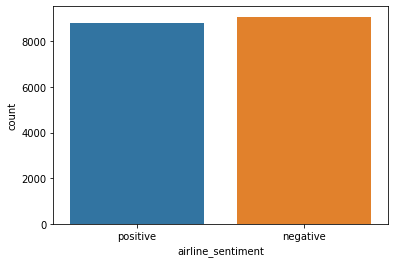

In [21]:
print(df['airline_sentiment'].value_counts())
sns.countplot(x='airline_sentiment', data=df)

Tokenisasi teks dan split data

In [22]:
lenght_text =len(df['text'])
max_words = len(set(" ".join(df['text']).split()))
lenght_text,max_words

(17879, 14157)

In [23]:
max_features = max_words
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(df['text'].values)
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X)
X

array([[   0,    0,    0, ..., 1950,   89, 5444],
       [   0,    0,    0, ...,   21,  330, 3262],
       [   0,    0,    0, ...,  209,  122,  341],
       ...,
       [   0,    0,    0, ..., 1928,   91,  301],
       [   0,    0,    0, ...,  103, 1534, 1917],
       [   0,    0,    0, ..., 6152, 3652, 3425]])

In [24]:
Y = pd.get_dummies(df['airline_sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(12515, 23) (12515, 2)
(5364, 23) (5364, 2)


In [25]:
Y_train

array([[1, 0],
       [1, 0],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

LSTM MODEL

In [26]:
embed_dim = 64
lstm_out = 100
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length= X.shape[1]))
model.add(LSTM(lstm_out, dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 64)            904000    
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 2)                 202       
                                                                 
Total params: 970,202
Trainable params: 970,202
Non-trainable params: 0
_________________________________________________________________
None


In [27]:
early_stop = EarlyStopping(monitor='val_loss',patience=2)
Model = model.fit(X_train, Y_train, epochs=20, batch_size=32,validation_data=(X_test, Y_test),verbose=1, callbacks=[early_stop]) 

Epoch 1/20
391/391 [==============================] - 18s 34ms/step - loss: 0.3136 - accuracy: 0.8557 - val_loss: 0.1820 - val_accuracy: 0.9302
Epoch 2/20
391/391 [==============================] - 10s 26ms/step - loss: 0.0957 - accuracy: 0.9647 - val_loss: 0.1549 - val_accuracy: 0.9410
Epoch 3/20
391/391 [==============================] - 11s 28ms/step - loss: 0.0479 - accuracy: 0.9831 - val_loss: 0.1613 - val_accuracy: 0.9379
Epoch 4/20
391/391 [==============================] - 12s 31ms/step - loss: 0.0269 - accuracy: 0.9906 - val_loss: 0.2172 - val_accuracy: 0.9308


In [28]:
score = model.evaluate(X_test, Y_test, verbose=1)
print("Loss = ", score[0])
print("Accuracy = ", score[1])

168/168 [==============================] - 1s 6ms/step - loss: 0.2172 - accuracy: 0.9308
Loss =  0.21723300218582153
Accuracy =  0.9307835698127747


In [29]:
Y_test

array([[1, 0],
       [0, 1],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [0, 1]], dtype=uint8)

In [30]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
Y_test = np.argmax(Y_test, axis=1)
accuracy_score(Y_test, y_pred)

168/168 [==============================] - 1s 6ms/step


0.9307835820895523

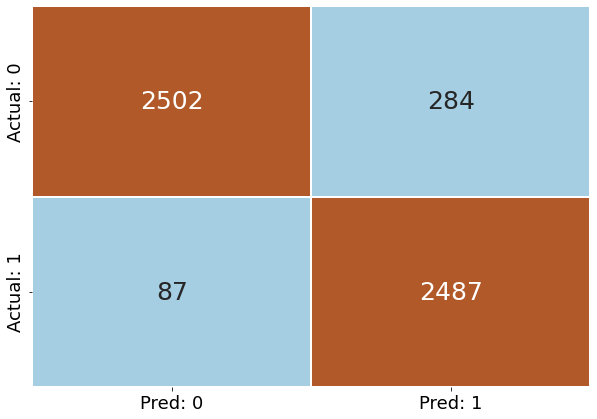

In [31]:
conf_mtx = confusion_matrix(Y_test, y_pred)
plt.rcParams['figure.figsize'] = [10,7]
conf_mat = pd.DataFrame(data=conf_mtx, columns=['Pred: 0', 'Pred: 1'], index=['Actual: 0', 'Actual: 1'])
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Paired', cbar=False, linewidths=0.1, annot_kws={'size':25})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.show()

In [32]:
# test
sample = ['I\'d love to fly with this airline again', 'bad services', 'i hate it, bad services', 'Services are sucks']
sample_copy = sample.copy()
sample = tokenizer.texts_to_sequences(sample)
sample = pad_sequences(sample, maxlen=31, dtype='int32', value=0)
print(sample)
sentiments = model.predict(sample, batch_size=1, verbose=2)
print()
for i in range(len(sentiments)):
  print(sample_copy[i]+": ")
  if np.argmax(sentiments[i]) == 0:
    print('Negative')
  elif np.argmax(sentiments[i]) == 1:
    print('Positive')

[[    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0    43    46    33]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0   124   876]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0 12499   693   124   876]
 [    0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0   876   533]]
4/4 - 0s - 354ms/epoch - 88ms/step

I'd love to fly with this airline again: 
Positive
bad services: 
Negative
i hate it, bad services: 
Negative
Services are sucks: 
Negative
